<a href="https://colab.research.google.com/github/sainithinkatta/deep_learning_class/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 5 - Self-Supervised Learning**

In this homework, we will introduce four different autoencoders for the task of anomaly detection.

# Set up the environment


## Package installation

In [64]:
# Training progress bar
!pip install -q qqdm
!pip install -q tqdm

## Untar data

hw5_data contains 2 files
```
hw5_data/
├── trainingset.npy
├── testingset.npy
```

# Import packages

In [2]:
import numpy as np
import random
import torch
import torchvision

from torch.utils.data import DataLoader
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import torchvision.transforms as transforms

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from torch.optim import Adam, AdamW

from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import vq, kmeans

from qqdm import qqdm, format_str
import tqdm
import pandas as pd

import matplotlib.pyplot as plt

import pdb  # use pdb.set_trace() to set breakpoints for debugging




# Loading data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/Colab Notebooks/hw5_data-2.zip" /content/

!unzip /content/hw5_data-2.zip -d /content/

!ls /content/hw5_data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/hw5_data-2.zip
  inflating: /content/hw5_data/testingset.npy  
  inflating: /content/hw5_data/trainingset.npy  
hw5_data  testingset.npy  trainingset.npy


In [6]:
train = np.load('/content/hw5_data/trainingset.npy', allow_pickle=True)
test = np.load('/content/hw5_data/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(850, 64, 64, 3)
(150, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [7]:
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(12345678)

# Autoencoder

# Models & loss (16pts)

In [34]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64*64*3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)) # (1pt) Todo: Use a linear layer with proper # of input_channels and # of output_channels

        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 64 * 64 * 3),
            nn.Tanh()  ) # (1pt) Todo: Use a Tanh as an activation layer

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# maybe it can be smaller
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # (1pt) Todo: Use a conv layer with proper # of input_channels and # of output_channels with kernel_size=4, stride=2 and padding=1
            nn.ReLU()    , # (1pt) Todo: Use a ReLu as an activation layer
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), # (1pt) Todo: Use a transpose conv layer with proper # of input_channels and # of output_channels with kernel_size=4, stride=2 and padding=1
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # (1pt) Todo: Use a transpose conv layer with proper # of input_channels and # of output_channels with kernel_size=4, stride=2 and padding=1
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),  # (1pt) Todo: Use a conv layer with proper # of input_channels and # of output_channels with kernel_size=4, stride=2 and padding=1
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1), # (1pt) Todo: Use a conv layer with proper # of input_channels and # of output_channels with kernel_size=4, stride=2 and padding=1
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1), # (1pt) Todo: Use a conv layer with proper # of input_channels and # of output_channels with kernel_size=4, stride=2 and padding=1
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), # (1pt) Todo: Use a transpose conv layer with proper # of input_channels and # of output_channels with kernel_size=4, stride=2 and padding=1
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)  # mse loss
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD


class Resnet(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(Resnet, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)   , # (1pt) Todo: Use a batchnorm1d layer with proper input_size and momentum=0.01
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)

        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4) , # (1pt) Todo: Use a batchnorm1d layer with proper input_size
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # (1pt)Todo :Flatten output of conv

        # FC layers
        if x.shape[0] > 1:
            x = self.bn1(self.fc1(x))
        else:
            x = self.fc1(x)
        x = self.relu(x)
        if x.shape[0] > 1:
            x = self.bn2(self.fc2(x))
        else:
            x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3_mu(x)
        return x

    def decode(self, z):
        if z.shape[0] > 1:
            x = self.relu(self.fc_bn4(self.fc4(z)))
            x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        else:
            x = self.relu(self.fc4(z))
            x = self.relu(self.fc5(x)).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=True)  # (1pt)Todo : Use a bi-linear interpolation to size of (64,64) with align_corners=True
        return x

    def forward(self, x):
        z = self.encode(x)
        x_reconst = self.decode(z)

        return x_reconst


# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [35]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            # self.tensors = tensors.permute(0, 3, 1, 2)
            self.tensors = tensors.permute(0, 3, 1, 2)

        # You may add some transforms below
        self.transform = transforms.Compose([
                            transforms.Lambda(lambda x: x.to(torch.float32)),
                            transforms.Lambda(lambda x: 2. * x/255. - 1.),
                            # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])

    def __getitem__(self, index):
        x = self.tensors[index]

        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Initialize
- hyperparameters
- dataloader
- model
- optimizer & loss


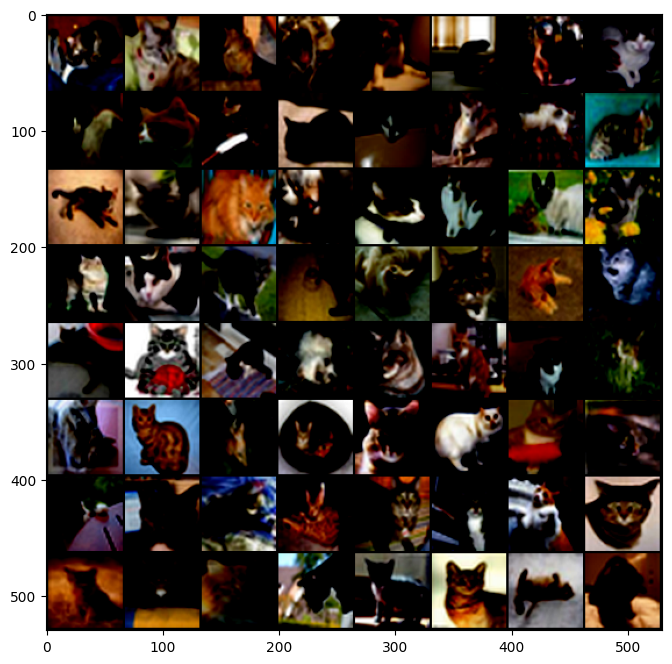

In [36]:
# Training hyperparameters
num_epochs = 20
batch_size = 1024
learning_rate = 1e-6

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

images = [train_dataset[i] for i in range(64)]
grid_img = torchvision.utils.make_grid(images, nrow=8)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Resnet

In [37]:
# Model
model_type = 'resnet'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'resnet': Resnet(), 'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), }
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

## Training loop

In [54]:
best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Training'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
      'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
      'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                                                   
 0/20           -             -                                                                     
Training   0.0% |                                                                                  | Iters    Elapsed Time      Speed    epoch    loss                                                  
 2/20   00:00:00<00:00:03  5.62it/s  2/20   5214.6108                                               
Training  10.0% |████████                                                                          | Iters    Elapsed Time      Speed    epoch    loss                                                  
 4/20   00:00:00<00:00:02  5.86it/s  4/20   5204.8320                                               
Training  20.0% |████████████████                                                                  | Iters    Elapsed Time      Speed    epoch    loss                                            

# FCN_autoencoder

In [55]:
# Model
model_type = 'fcn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'resnet': Resnet(), 'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), }
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

## Training loop

In [57]:
best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Training'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
      'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
      'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                                                   
 0/20           -             -                                                                     
Training   0.0% |                                                                                  | Iters    Elapsed Time      Speed    epoch   loss                                                   
 2/20   00:00:00<00:00:02  6.37it/s  2/20   0.2723                                                  
Training  10.0% |████████                                                                          | Iters    Elapsed Time      Speed    epoch   loss                                                   
 4/20   00:00:00<00:00:02  6.71it/s  4/20   0.2723                                                  
Training  20.0% |████████████████                                                                  | Iters    Elapsed Time      Speed    epoch   loss                                             

# Conv_Autoencoder

In [58]:
# Model
model_type = 'cnn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'resnet': Resnet(), 'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), }
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

## Training loop

In [60]:
best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Training'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
      'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
      'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                                                   
 0/20           -             -                                                                     
Training   0.0% |                                                                                  | Iters    Elapsed Time      Speed    epoch   loss                                                   
 2/20   00:00:00<00:00:03  5.98it/s  2/20   0.2636                                                  
Training  10.0% |████████                                                                          | Iters    Elapsed Time      Speed    epoch   loss                                                   
 4/20   00:00:00<00:00:02  6.19it/s  4/20   0.2635                                                  
Training  20.0% |████████████████                                                                  | Iters    Elapsed Time      Speed    epoch   loss                                             

# VAE

In [61]:
# Model
model_type = 'vae'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'resnet': Resnet(), 'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), }
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

## Training loop

In [63]:
best_loss = np.inf
model.train()

qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Training'))
for epoch in qqdm_train:
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_{}.pt'.format(model_type))
    # ===================log========================
    qqdm_train.set_infos({
      'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',
      'loss': f'{mean_loss:.4f}',
    })
    # ===================save_last========================
    torch.save(model, 'last_model_{}.pt'.format(model_type))

 Iters    Elapsed Time      Speed                                                                   
 0/20           -             -                                                                     
Training   0.0% |                                                                                  | Iters    Elapsed Time      Speed    epoch    loss                                                  
 2/20   00:00:00<00:00:03  5.23it/s  2/20   4391.3135                                               
Training  10.0% |████████                                                                          | Iters    Elapsed Time      Speed    epoch    loss                                                  
 4/20   00:00:00<00:00:02  5.66it/s  4/20   4384.3325                                               
Training  20.0% |████████████████                                                                  | Iters    Elapsed Time      Speed    epoch    loss                                            